Missing values in each column before processing:
Date                         0
Hour                         0
Discharge Rate (cumecs)     11
Rainfall Data (mm)         122
Water Level (m)             11
dtype: int64
Missing values in each column after processing:
Date                       0
Hour                       0
Discharge Rate (cumecs)    0
Rainfall Data (mm)         0
Water Level (m)            0
dtype: int64


C:\Users\Janith\AppData\Local\Temp\ipykernel_51116\371994753.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Accuracy for 1st hour prediction: 84.05%
Accuracy for 2nd hour prediction: 66.29%
Accuracy for 3rd hour prediction: 53.53%
   Actual (Next 1st hour)  Predicted (Next 1st hour)  Actual (Next 2nd hour)  \
0                    2.20                       2.28                    2.15   
1                    1.04                       1.06                    1.02   
2                    2.40                       2.42                    2.28   
3                    2.18                       2.16                    2.09   
4                    3.67                       3.65                    3.67   
5                    0.88                       0.94                    0.84   
6                    7.27                       7.04                    7.38   
7                    3.30                       3.21                    3.37   
8                    2.42                       2.43                    2.30   
9                    5.43                       5.51                    5.23 

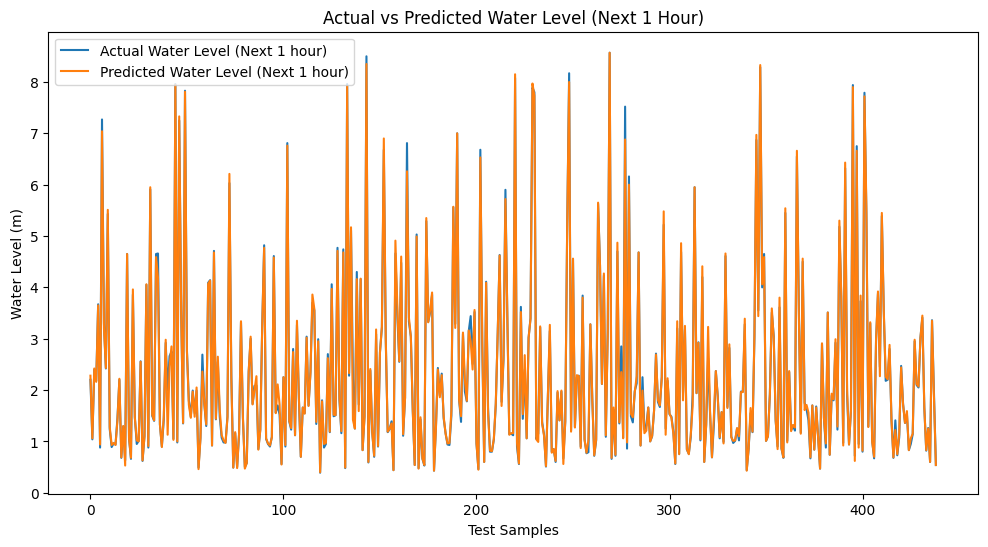

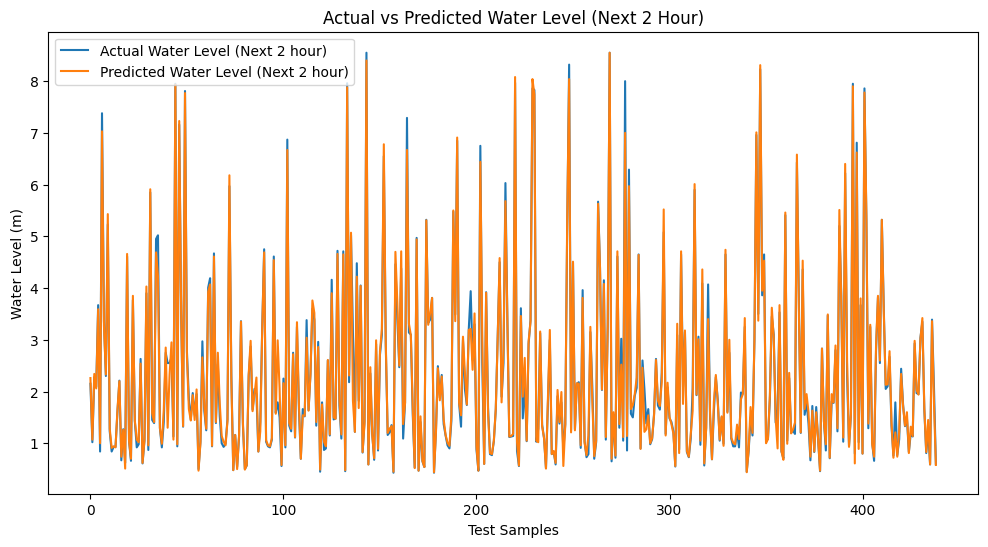

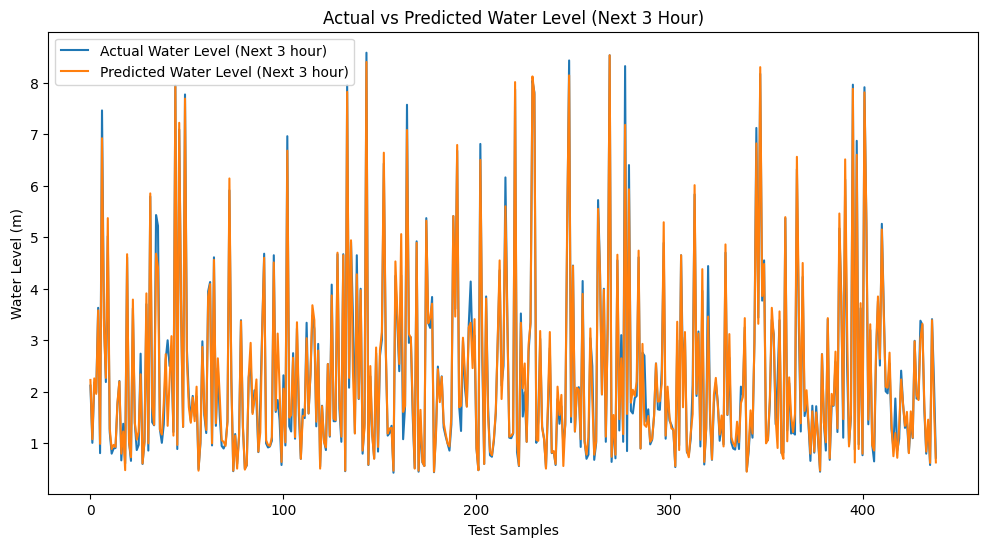

Mean Absolute Error for 1st hour prediction: 0.06
Mean Absolute Error for 2nd hour prediction: 0.11
Mean Absolute Error for 3rd hour prediction: 0.15


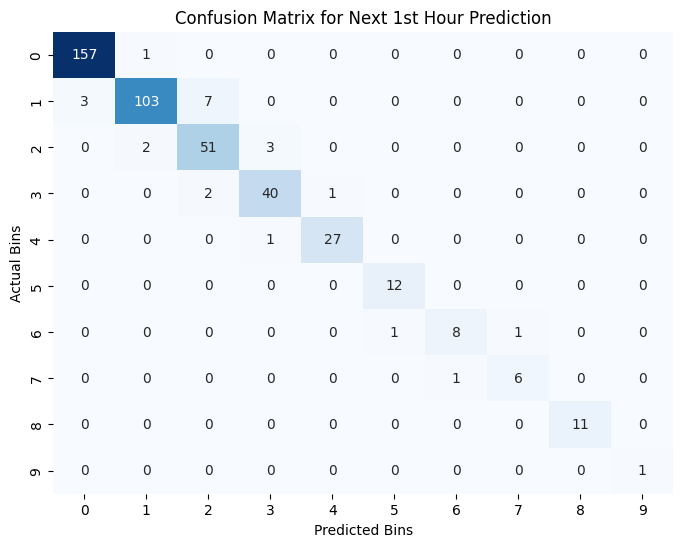

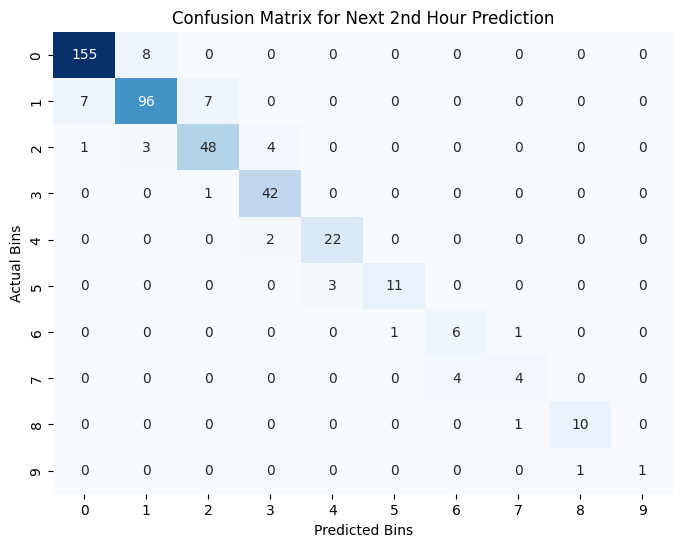

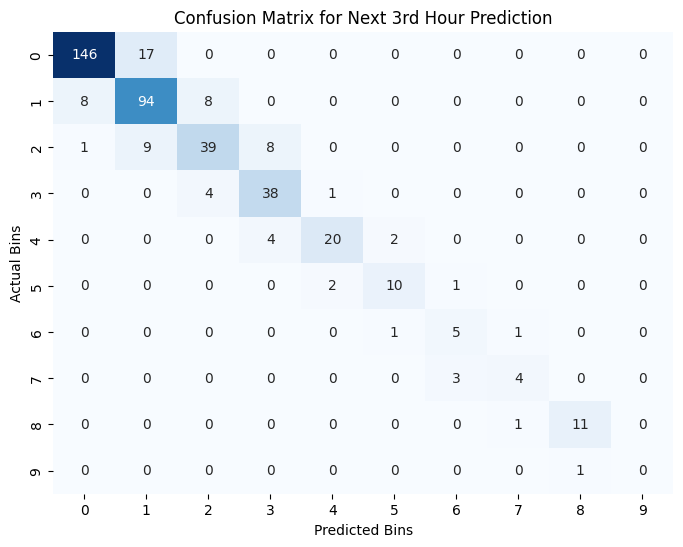

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns


# Load the dataset
file_path = 'F:/FYP project/FYP(Flood)/Real Data/new full data.csv'
df = pd.read_csv(file_path)

# Check for null values
print("Missing values in each column before processing:")
print(df.isnull().sum())

# Method 1: Forward Fill (propagate last valid observation forward to fill nulls)
df.fillna(method='ffill', inplace=True)

# Method 2: Interpolation (optional, if you want to interpolate instead of forward fill)
# df.interpolate(method='linear', inplace=True)

# Recheck for null values after filling
print("Missing values in each column after processing:")
print(df.isnull().sum())

# Extract input features and target (Water Level for next 1st, 2nd, 3rd hours)
X = df[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = np.array([df['Water Level (m)'].shift(-i) for i in range(1, 4)]).T[:-3]

# Remove the last three rows since they don't have the target data
X = X[:-3]

# Prepare data using 3 rows (time steps) as input to predict next 3 hours
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

time_steps = 3
X_seq, y_seq = create_sequences(X, y, time_steps)

# Flatten the sequences for Random Forest (since Random Forest doesn't handle sequences like LSTM)
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq_flat, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForestRegressor for each hour (1st, 2nd, and 3rd hour predictions)
rf_1st_hour = RandomForestRegressor(n_estimators=100, random_state=42)
rf_2nd_hour = RandomForestRegressor(n_estimators=100, random_state=42)
rf_3rd_hour = RandomForestRegressor(n_estimators=100, random_state=42)

rf_1st_hour.fit(X_train_scaled, y_train[:, 0])
rf_2nd_hour.fit(X_train_scaled, y_train[:, 1])
rf_3rd_hour.fit(X_train_scaled, y_train[:, 2])

# Make predictions
y_pred_1st_hour = rf_1st_hour.predict(X_test_scaled)
y_pred_2nd_hour = rf_2nd_hour.predict(X_test_scaled)
y_pred_3rd_hour = rf_3rd_hour.predict(X_test_scaled)

# Combine predictions into a single array
y_pred = np.column_stack([y_pred_1st_hour, y_pred_2nd_hour, y_pred_3rd_hour])

# Round the predictions to 2 decimal places
y_pred = np.round(y_pred, 2)
y_test = np.round(y_test, 2)

# Calculate accuracy for each hour's prediction
def calculate_accuracy(y_true, y_pred, threshold=0.1):
    """Calculate accuracy by checking if predicted values are within a threshold of actual values."""
    return np.mean(np.abs(y_true - y_pred) <= threshold)

accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_pred[:, 0])
accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_pred[:, 1])
accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_pred[:, 2])

print(f"Accuracy for 1st hour prediction: {accuracy_1st_hour * 100:.2f}%")
print(f"Accuracy for 2nd hour prediction: {accuracy_2nd_hour * 100:.2f}%")
print(f"Accuracy for 3rd hour prediction: {accuracy_3rd_hour * 100:.2f}%")

# Create confusion matrices for each hour's prediction
def create_confusion_matrix(y_true, y_pred, threshold=0.1):
    """Create confusion matrix based on whether predictions are within the threshold."""
    y_true_binary = (y_true > np.mean(y_true)).astype(int)
    y_pred_binary = (y_pred > np.mean(y_pred)).astype(int)
    return confusion_matrix(y_true_binary, y_pred_binary)

conf_matrix_1st_hour = create_confusion_matrix(y_test[:, 0], y_pred[:, 0])
conf_matrix_2nd_hour = create_confusion_matrix(y_test[:, 1], y_pred[:, 1])
conf_matrix_3rd_hour = create_confusion_matrix(y_test[:, 2], y_pred[:, 2])

# Comparing actual vs predicted for first 10 values
comparison_df = pd.DataFrame({
    'Actual (Next 1st hour)': y_test[:, 0],
    'Predicted (Next 1st hour)': y_pred[:, 0],
    'Actual (Next 2nd hour)': y_test[:, 1],
    'Predicted (Next 2nd hour)': y_pred[:, 1],
    'Actual (Next 3rd hour)': y_test[:, 2],
    'Predicted (Next 3rd hour)': y_pred[:, 2]
})

print(comparison_df.head(10))

# Plot actual vs predicted for each of the next 3 hours
for i in range(3):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label=f'Actual Water Level (Next {i+1} hour)')
    plt.plot(y_pred[:, i], label=f'Predicted Water Level (Next {i+1} hour)')
    plt.title(f'Actual vs Predicted Water Level (Next {i+1} Hour)')
    plt.xlabel('Test Samples')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.show()

# Calculate and display MAE for each hour prediction
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_pred[:, 2])

print(f'Mean Absolute Error for 1st hour prediction: {mae_1st_hour:.2f}')
print(f'Mean Absolute Error for 2nd hour prediction: {mae_2nd_hour:.2f}')
print(f'Mean Absolute Error for 3rd hour prediction: {mae_3rd_hour:.2f}')

# Create confusion matrices by binning the actual and predicted values into ranges
def create_binned_confusion_matrix(y_true, y_pred, hour):
    bins = np.linspace(min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()), 10)  # Create 10 bins
    y_true_binned = np.digitize(y_true, bins)
    y_pred_binned = np.digitize(y_pred, bins)
    
    conf_matrix = confusion_matrix(y_true_binned, y_pred_binned)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Next {hour} Hour Prediction')
    plt.xlabel('Predicted Bins')
    plt.ylabel('Actual Bins')
    plt.show()

# Generate confusion matrices for next 1st, 2nd, and 3rd hour predictions
create_binned_confusion_matrix(y_test[:, 0], y_pred[:, 0], '1st')
create_binned_confusion_matrix(y_test[:, 1], y_pred[:, 1], '2nd')
create_binned_confusion_matrix(y_test[:, 2], y_pred[:, 2], '3rd')
